## Dataset preparation
This notebook imports participant data from TIME study, keeps only those who completed the study, comutes all the features, then saves two files:
1. Feature set for all the users
2. A sample of users to try different ML algorithms

## Import libraries
Import essential libraries here.

In [2]:
import sys
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

## Import participant status
We will import participant status data. So that we can filter out those who completed the study

In [13]:
## Import the status file
status_file = '/Users/adityaponnada/Downloads/time_study_data/participant_status_tracking_v2.csv'
status_df = pd.read_csv(status_file)

## Show the first few rows
print(status_df.head())
# Also print the columns names
print(status_df.columns)

   Record ID            Visualizer ID Participant Status  Consent Date  \
0       9001       sharpnessnextpouch           Completed    3/17/2020   
1       9002     uniformlyharmfulbush          Unenrolled    3/18/2020   
2       9003     hacksawscoldingdares            Withdrew    3/27/2020   
3       9004    dimnesscranialunheard           Completed    3/28/2020   
4       9005  coynessculminatebarista           Completed     4/8/2020   

  Date participant completed Date participant withdrew  \
0                  3/17/2021                       NaN   
1                        NaN                       NaN   
2                        NaN                 12/4/2020   
3                  3/28/2021                       NaN   
4                   4/8/2021                       NaN   

  Date participant unenrolled Date Devices Mailed ID of device loaned  \
0                         NaN           3/25/2020        C2F9214C2188   
1                  10/20/2020           3/25/2020        C2F

Now only keep the completed participants

In [14]:
## Filter completed participants. We will only keep the visualizerID and status columns
status_df = status_df[status_df['Participant Status '] == 'Completed'][['Visualizer ID', 'Participant Status ']]
# Rename the visualizerID column to participant_id.
status_df.rename(columns={'Visualizer ID': 'participant_id'}, inplace=True)
# Also rename participant status to status
status_df.rename(columns={'Participant Status ': 'status'}, inplace=True)
# Reset the index
status_df.reset_index(drop=True, inplace=True)
# Add @timestudy_com to the participant_id column
status_df['participant_id'] = status_df['participant_id'] + '@timestudy_com'
## Show the first few rows
print(status_df.head())
# Also print the shape of the dataframe
print(status_df.shape)


                           participant_id     status
0        sharpnessnextpouch@timestudy_com  Completed
1     dimnesscranialunheard@timestudy_com  Completed
2   coynessculminatebarista@timestudy_com  Completed
3  spinstersubatomiccoyness@timestudy_com  Completed
4     sadlyskilledlustfully@timestudy_com  Completed
(136, 2)


Save the completed participants IDs as a list

In [15]:
completed_participants = status_df['participant_id'].sort_values().tolist()
# Display the completed participants
print(completed_participants)
print(f"Total completed participants: {len(completed_participants)}")

['afflictedrevenueepilepsy@timestudy_com', 'anagramprobingscrooge@timestudy_com', 'animateshowerclothes@timestudy_com', 'anthillfastinglucrative@timestudy_com', 'arrivejanitoruniformly@timestudy_com', 'atlanticchefhatchet@timestudy_com', 'attirecrabbinghumbling@timestudy_com', 'backfirebankedprudishly@timestudy_com', 'badlandwiltmuseum@timestudy_com', 'bannisterhardwiredladle@timestudy_com', 'bartenderradiatorapplied@timestudy_com', 'beavertomatoupscale@timestudy_com', 'bondingcoasterdirtiness@timestudy_com', 'brinkaminounframed@timestudy_com', 'catsupexploitmocker@timestudy_com', 'caucuscattlemockup@timestudy_com', 'certifiedembargobartender@timestudy_com', 'chewingslouchingfailing@timestudy_com', 'childhoodmovingmagnify@timestudy_com', 'cohesiveprotractfavored@timestudy_com', 'collisionmolarbreeze@timestudy_com', 'congestedculpritsaved@timestudy_com', 'congestedtapssneer@timestudy_com', 'congresscyclistdefender@timestudy_com', 'copybrickcreative@timestudy_com', 'coynessculminatebaris

In [21]:
# Split completed_participants into training_list and holdout_list with non-deterministic sampling
import random

n_train = min(100, len(completed_participants))
if len(completed_participants) == 0:
    training_list = []
    holdout_list = []
else:
    # random.sample is non-deterministic by default (system RNG); each run will differ
    training_list = random.sample(completed_participants, k=n_train)
    holdout_set = set(training_list)
    # preserve original order for holdout_list
    holdout_list = [p for p in completed_participants if p not in holdout_set]

print(f'Training list size: {len(training_list)}')
print(f'Holdout list size: {len(holdout_list)}')
print('Training sample (first 10):', training_list[:10])
print('Holdout sample (first 10):', holdout_list[:10])

Training list size: 100
Holdout list size: 36
Training sample (first 10): ['headphoneoutsmartunfailing@timestudy_com', 'retrialgraftedsturdy@timestudy_com', 'landlordastrologycopy@timestudy_com', 'bartenderradiatorapplied@timestudy_com', 'backfirebankedprudishly@timestudy_com', 'bannisterhardwiredladle@timestudy_com', 'unfreezefrayingknoll@timestudy_com', 'endlessroamerreconfirm@timestudy_com', 'unmixableresultfidgety@timestudy_com', 'equallustinessuntil@timestudy_com']
Holdout sample (first 10): ['animateshowerclothes@timestudy_com', 'atlanticchefhatchet@timestudy_com', 'beavertomatoupscale@timestudy_com', 'bondingcoasterdirtiness@timestudy_com', 'childhoodmovingmagnify@timestudy_com', 'cohesiveprotractfavored@timestudy_com', 'collisionmolarbreeze@timestudy_com', 'congestedculpritsaved@timestudy_com', 'congestedtapssneer@timestudy_com', 'crestedserpentspongy@timestudy_com']


## Import compliance matrix
We will import hourly compliance matrix for all the completed participants

In [22]:
# Load uema_feature_mx_*.csv only for participants in completed_participants
import os, gc, glob
from pandas.errors import EmptyDataError

root_folder = '/Users/adityaponnada/Downloads/time_study_data/compliance_matrix/'
chunk_size = 10000

# normalize and dedupe completed_participants (preserve order)
normalized = []
seen = set()
for p in training_list:
    key = str(p).strip()
    if key not in seen:
        seen.add(key)
        normalized.append(key)
training_list = normalized

# Only keep IDs that match the expected folder pattern (example: *@timestudy_com)
training_list = [p for p in training_list if p.endswith('@timestudy_com')]

# accumulator for per-participant DataFrames (keeps memory lower than appending many small dfs)
participant_dfs = []

for pid in training_list:
    participant_folder = os.path.join(root_folder, pid)
    if not os.path.isdir(participant_folder):
        # skip missing participant folders
        continue
    # find files matching pattern
    files = sorted(glob.glob(os.path.join(participant_folder, 'uema_feature_mx_*.csv')))
    if not files:
        continue
    # read files for this participant in chunks and accumulate into a list
    print(f'Reading participant: {pid} | files: {len(files)}')
    per_parts = []
    for fp in files:
        try:
            reader = pd.read_csv(fp, chunksize=chunk_size, low_memory=True)
            for chunk in reader:
                per_parts.append(chunk)
        except EmptyDataError:
            # skip empty files
            continue
        except Exception as e:
            print(f'Failed reading {fp}: {e}')
    if per_parts:
        # concat per-participant chunks to a single dataframe to reduce number of objects
        try:
            df_pid = pd.concat(per_parts, ignore_index=True)
        except ValueError:
            # in case concat fails, skip this participant
            continue
        # optionally tag the source participant id so downstream code knows origin
        df_pid['participant_id_source'] = pid
        participant_dfs.append(df_pid)
        # cleanup
        del per_parts
        gc.collect()

# Final concatenation across participants
if participant_dfs:
    compliance_matrix = pd.concat(participant_dfs, ignore_index=True)
else:
    compliance_matrix = pd.DataFrame()

# report
print('Final compliance_matrix rows,cols:', compliance_matrix.shape)
if not compliance_matrix.empty:
    print('Approx memory (bytes):', compliance_matrix.memory_usage(deep=True).sum())


Reading participant: headphoneoutsmartunfailing@timestudy_com | files: 276
Reading participant: retrialgraftedsturdy@timestudy_com | files: 84
Reading participant: landlordastrologycopy@timestudy_com | files: 225
Reading participant: retrialgraftedsturdy@timestudy_com | files: 84
Reading participant: landlordastrologycopy@timestudy_com | files: 225
Reading participant: bartenderradiatorapplied@timestudy_com | files: 94
Reading participant: backfirebankedprudishly@timestudy_com | files: 251
Reading participant: bartenderradiatorapplied@timestudy_com | files: 94
Reading participant: backfirebankedprudishly@timestudy_com | files: 251
Reading participant: bannisterhardwiredladle@timestudy_com | files: 268
Reading participant: bannisterhardwiredladle@timestudy_com | files: 268
Reading participant: unfreezefrayingknoll@timestudy_com | files: 243
Reading participant: unfreezefrayingknoll@timestudy_com | files: 243
Reading participant: endlessroamerreconfirm@timestudy_com | files: 209
Reading 

In [23]:
## Get the number of rows in compliance_matrix
num_rows = compliance_matrix.shape[0]
print(f"Number of rows in compliance_matrix: {num_rows}")
# Get the number of columns in compliance_matrix
num_cols = compliance_matrix.shape[1]
print(f"Number of columns in compliance_matrix: {num_cols}")
# Get the number of unique participants in compliance_matrix
num_participants = compliance_matrix['Participant_ID'].nunique()
print(f"Number of unique participants in compliance_matrix: {num_participants}")

Number of rows in compliance_matrix: 1088971
Number of columns in compliance_matrix: 63
Number of unique participants in compliance_matrix: 101


In [24]:
print(len(training_list))

100


In [25]:
## Remove rows with participant_id is "unknown_user"
compliance_matrix = compliance_matrix[compliance_matrix['Participant_ID'] != 'unknown_user']

Save the file for later access

In [26]:
## Save compliance_matrix to a csv file. The filename should have _date_time appended to it.
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
compliance_matrix.to_csv(f'/Users/adityaponnada/Downloads/time_study_data/compliance_matrix_{current_time}.csv', index=False)
print(f"Compliance matrix saved to /Users/adityaponnada/Downloads/time_study_data/compliance_matrix_{current_time}.csv")

Compliance matrix saved to /Users/adityaponnada/Downloads/time_study_data/compliance_matrix_20251208_183728.csv


In [27]:
## Write training list and holdout list to separate text files
with open(f'/Users/adityaponnada/Downloads/time_study_data/training_list_{current_time}.txt', 'w') as f:
    for item in training_list:
        f.write(f"{item}\n")
print(f"Training list saved to /Users/adityaponnada/Downloads/time_study_data/training_list_{current_time}.txt")

with open(f'/Users/adityaponnada/Downloads/time_study_data/holdout_list_{current_time}.txt', 'w') as f:
    for item in holdout_list:
        f.write(f"{item}\n")
print(f"Holdout list saved to /Users/adityaponnada/Downloads/time_study_data/holdout_list_{current_time}.txt")


Training list saved to /Users/adityaponnada/Downloads/time_study_data/training_list_20251208_183728.txt
Holdout list saved to /Users/adityaponnada/Downloads/time_study_data/holdout_list_20251208_183728.txt


### Sample 100 participants [SKIP]
We just sample ten participants for model testing for now

In [8]:
## Sample 10 participants from completed participants
sampled_participants = np.random.choice(completed_participants, size=100, replace=False)
print("Sampled Participants:")
for participant in sampled_participants:
    print(participant)

# Subset the compliance matrix to only include the sampled participants and save it in a new data frame
sampled_compliance_matrix = compliance_matrix[compliance_matrix['Participant_ID'].isin(sampled_participants)]
# Show the first few rows of the sampled compliance matrix
print(sampled_compliance_matrix.head())
# Also print the shape of the sampled compliance matrix
print(sampled_compliance_matrix.shape)

# Save the sampled compliance matrix to a csv file
sampled_compliance_matrix.to_csv(f'/Users/adityaponnada/Downloads/time_study_data/sample_100_compliance_matrix_{current_time}.csv', index=False)
print(f"Sampled compliance matrix saved to /Users/adityaponnada/Downloads/time_study_data/sample_100_compliance_matrix_{current_time}.csv")

Sampled Participants:
unbundleoverbitesixtyfold@timestudy_com
reliablydetaildebate@timestudy_com
wikipediaetchingcrystal@timestudy_com
freightbrisklypopulace@timestudy_com
slapstickporcupineslacks@timestudy_com
rangerchildlikequantum@timestudy_com
tapestryrivetingverify@timestudy_com
lardcapablemud@timestudy_com
tipoffstarchpartly@timestudy_com
housewagontrivial@timestudy_com
persevereriseswoop@timestudy_com
retrievergeckoabroad@timestudy_com
espionagechihuahuagraffiti@timestudy_com
kinsmanlargewand@timestudy_com
sharpnessnextpouch@timestudy_com
equallustinessuntil@timestudy_com
unveileddismountearwig@timestudy_com
genderradiantlycharging@timestudy_com
predatordebatingpredator@timestudy_com
penpalsandbanklifting@timestudy_com
exploreparadoxmangle@timestudy_com
spinstersubatomiccoyness@timestudy_com
mountainseclusionchaffing@timestudy_com
idealistsustainerexpansive@timestudy_com
congresscyclistdefender@timestudy_com
parakeettrappeddetector@timestudy_com
retrialgraftedsturdy@timestudy_co

Inspect the sample data

In [28]:
## Get the number of rows per participant in the sampled compliance matrix
rows_per_participant = compliance_matrix['Participant_ID'].value_counts()
print("Number of rows per participant in the sampled compliance matrix:")
print(rows_per_participant)

Number of rows per participant in the sampled compliance matrix:
Participant_ID
starlesspayingoutlet@timestudy_com         16254
urchinvariablytrend@timestudy_com          15868
headwearskirmishantidote@timestudy_com     15798
pretendedconstrainfraying@timestudy_com    15440
showplacefacingsanta@timestudy_com         14793
                                           ...  
retrialgraftedsturdy@timestudy_com          3707
housewagontrivial@timestudy_com             2245
facelesschimpacclaim@timestudy_com           975
thusflattenengraver@timestudy_com            768
retrievergeckoabroad@timestudy_com            55
Name: count, Length: 100, dtype: int64


In [29]:
## Print the names of the columns in the sampled compliance matrix
print("Columns in the sampled compliance matrix:")
for col in compliance_matrix.columns:
    print(col)

Columns in the sampled compliance matrix:
Participant_ID
Initial_Prompt_Date
Prompt_Type
Study_Mode
Initial_Prompt_Local_Time
Answer_Status
Actual_Prompt_Local_Time
First_Question_Completion_Unixtime
UTC_Offset
Reprompt_Num
Line
Actual_Prompt_Local_DateTime
DAY_OF_THE_WEEK
TIME_OF_THE_DAY
DAYS_IN_THE_STUDY
BATTERY_LEVEL
CHARGING_STATUS
match_time_battery
LOCATION
match_time_location
DISTANCE_FROM_HOME
LOCATION_LABEL
SCREEN_STATUS
match_time_screen
WAKE_TIME
SLEEP_TIME
PHONE_LOCK
LAST_USAGE_DURATION
match_time_lock
PARTS_OF_WAKING_HOUR
PROXIMITY_TO_WAKE_TIME
PROXIMITY_TO_SLEEP_TIME
mims_summary_1min
num_readings_1min
start_time_1min
mims_summary_2min
num_readings_2min
start_time_2min
mims_summary_3min
num_readings_3min
start_time_3min
mims_summary_4min
num_readings_4min
start_time_4min
mims_summary_5min
num_readings_5min
start_time_5min
mims_summary_6min
num_readings_6min
start_time_6min
mims_summary_7min
num_readings_7min
start_time_7min
mims_summary_8min
num_readings_8min
start_time_8

## Feature processing
We will compute features from each of the relevant columns one by one.
First, we will write the function, then apply the function to the data frame.

In [30]:
## First create a copy of the sampled compliance matrix
processed_compliance_matrix = sampled_compliance_matrix.copy()
# Show the first few rows of the processed compliance matrix
print(processed_compliance_matrix.head())

                           Participant_ID Initial_Prompt_Date  \
132810  neutergoldfishsworn@timestudy_com          2021-02-22   
132811  neutergoldfishsworn@timestudy_com          2021-02-22   
132812  neutergoldfishsworn@timestudy_com          2021-02-22   
132813  neutergoldfishsworn@timestudy_com          2021-02-22   
132814  neutergoldfishsworn@timestudy_com          2021-02-22   

             Prompt_Type Study_Mode     Initial_Prompt_Local_Time  \
132810         EMA_Micro       TIME  Mon Feb 22 16:53:05 PST 2021   
132811      CS_EMA_Micro       TIME  Mon Feb 22 17:30:04 PST 2021   
132812         EMA_Micro       TIME  Mon Feb 22 17:38:04 PST 2021   
132813         EMA_Micro       TIME  Mon Feb 22 17:46:14 PST 2021   
132814  Trivia_EMA_Micro       TIME  Mon Feb 22 17:54:03 PST 2021   

       Answer_Status      Actual_Prompt_Local_Time  \
132810     Completed  Mon Feb 22 16:53:05 PST 2021   
132811     Completed  Mon Feb 22 17:30:04 PST 2021   
132812     Completed  Mon Feb 22

## The outcome variable
We will convert answer status into 0 or 1 based on whether it was answered or not,

In [31]:
## Inspect the answer status column
print("Unique values in the Answer_Status column:")
print(processed_compliance_matrix['Answer_Status'].unique())

Unique values in the Answer_Status column:
['Completed' 'NeverStarted' 'Started' 'PartiallyCompleted'
 'CompletedThenDismissed']


In [33]:
## Show sample rows from each category of the Answer_Status column
for status in processed_compliance_matrix['Answer_Status'].unique():
    print(f"Sample rows for Answer_Status = {status}:")
    sample_rows = processed_compliance_matrix[processed_compliance_matrix['Answer_Status'] == status].sample(n=1, random_state=42)
    print(sample_rows)
    print("\n")

Sample rows for Answer_Status = Completed:
                                 Participant_ID Initial_Prompt_Date  \
369579  pretendedconstrainfraying@timestudy_com          2021-06-24   

         Prompt_Type Study_Mode     Initial_Prompt_Local_Time Answer_Status  \
369579  CS_EMA_Micro       TIME  Thu Jun 24 07:59:46 PDT 2021     Completed   

            Actual_Prompt_Local_Time  First_Question_Completion_Unixtime  \
369579  Thu Jun 24 07:59:46 PDT 2021                       1624546805043   

       UTC_Offset  Reprompt_Num  ...          start_time_7min  \
369579  GMT-07:00             0  ...  2021-06-24 07:52:46.000   

       mims_summary_8min  num_readings_8min          start_time_8min  \
369579               0.0              480.0  2021-06-24 07:51:46.000   

       mims_summary_9min num_readings_9min          start_time_9min  \
369579               0.0             540.0  2021-06-24 07:50:46.000   

       mims_summary_10min num_readings_10min         start_time_10min  
369579     

In [34]:
## Check the distribution of answer status
answer_status_counts = processed_compliance_matrix['Answer_Status'].value_counts()
print("Distribution of Answer_Status:")
print(answer_status_counts)

Distribution of Answer_Status:
Answer_Status
Completed                 93246
NeverStarted              13691
Started                     550
CompletedThenDismissed      487
PartiallyCompleted          101
Name: count, dtype: int64


In [35]:
## Create a new column 'Outcome' based on the 'Answer_Status' column. 
## The value is 1 if the answer status is either Completed, CompletedThenDismissed, and Partially completed. Else it is 0 for other cases.
processed_compliance_matrix['Outcome'] = processed_compliance_matrix['Answer_Status'].apply(
    lambda x: 1 if x in ['Completed', 'CompletedThenDismissed', 'PartiallyCompleted'] else 0
)

In [36]:
## Check the distribution of the Outcome column
outcome_counts = processed_compliance_matrix['Outcome'].value_counts()
print("Distribution of Outcome:")
print(outcome_counts)

Distribution of Outcome:
Outcome
1    93834
0    14241
Name: count, dtype: int64


In [37]:
## Check the distribtion of the Outcome column in perceontage
outcome_percentage = processed_compliance_matrix['Outcome'].value_counts(normalize=True) * 100
print("Distribution of Outcome in percentage:")
print(outcome_percentage)

Distribution of Outcome in percentage:
Outcome
1    86.82304
0    13.17696
Name: proportion, dtype: float64


## Predicting features (At the prompt moment)
Now we will compute and prep predictor features one by one.

### Day of the week
We will convert day of the week into weekday (1) and weekend (0)

In [39]:
## Show distribution of the day of the week variable
day_of_week_counts = processed_compliance_matrix['DAY_OF_THE_WEEK'].value_counts()
print("Distribution of Day_of_Week:")
print(day_of_week_counts)

Distribution of Day_of_Week:
DAY_OF_THE_WEEK
2    20205
3    17919
1    17075
4    15791
0    13626
5    12348
6    11111
Name: count, dtype: int64


In [45]:
## As a test, sample one random row from the processed compliance matrix for each of the DAY_OF_THE_WEEK. 
## Save it in dataframe. We only want two columns - Prompt_Date and DAY_OF_THE_WEEK
sampled_day_of_week = processed_compliance_matrix.groupby('DAY_OF_THE_WEEK').apply(lambda x: x.sample(1)).reset_index(drop=True)
# Show the sampled day of week dataframe, but only two columns - Prompt_Date and DAY_OF_THE_WEEK
sampled_day_of_week = sampled_day_of_week[['Initial_Prompt_Date', 'DAY_OF_THE_WEEK']]
print("Sampled Day of Week DataFrame:")
print(sampled_day_of_week)

Sampled Day of Week DataFrame:
  Initial_Prompt_Date  DAY_OF_THE_WEEK
0          2021-01-11                0
1          2021-06-22                1
2          2021-08-11                2
3          2021-02-18                3
4          2022-04-22                4
5          2022-02-26                5
6          2021-07-18                6


/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_45934/1516588673.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_day_of_week = processed_compliance_matrix.groupby('DAY_OF_THE_WEEK').apply(lambda x: x.sample(1)).reset_index(drop=True)


In [52]:
## Create a new column is_weekend that is 1 if the DAY_OF_THE_WEEK is Saturday or Sunday, else 0.
## For this, values for DAY_OF_THE_WEEK are 0 for Monday, 1 for Tuesday, ..., 5 for Saturday, and 6 for Sunday.
processed_compliance_matrix['is_weekend'] = processed_compliance_matrix['DAY_OF_THE_WEEK'].apply(
    lambda x: 1 if x in [5, 6] else 0
)

# Show the first few rows of the processed compliance matrix with the new is_weekend column
print(processed_compliance_matrix['is_weekend'].head())

132810    0
132811    0
132812    0
132813    0
132814    0
Name: is_weekend, dtype: int64


In [53]:
## Show the distribution of weekend and weekday
weekend_counts = processed_compliance_matrix['is_weekend'].value_counts()
print("Distribution of is_weekend:")
print(weekend_counts)

Distribution of is_weekend:
is_weekend
0    84616
1    23459
Name: count, dtype: int64


### Time of the day
We will convert the prompt time in six parts - Early morning, morning, afternoon, evening, night, late night

In [64]:
## First check the data typoe of intial prompt time column
print("Data type of Initial_Prompt_Time column:")
print(processed_compliance_matrix['Actual_Prompt_Local_Time'].dtype)
## Show the first three rows of the Actual_Prompt_Local_Time column
print("First three rows of Actual_Prompt_Local_Time column:")
print(processed_compliance_matrix['Actual_Prompt_Local_Time'].head(3))

Data type of Initial_Prompt_Time column:
object
First three rows of Actual_Prompt_Local_Time column:
132810    Mon Feb 22 16:53:05 PST 2021
132811    Mon Feb 22 17:30:04 PST 2021
132812    Mon Feb 22 17:38:04 PST 2021
Name: Actual_Prompt_Local_Time, dtype: object


In [68]:
## Convert the prompt time in six parts - Early morning, morning, afternoon, evening, night, late night.
## We will create a new column 'Time_of_Day' based on the 'Prompt_Time' column. 
## Early morning  - 4 AM to 8 AM, morning 8 AM - 12 noon, afternoon 12 noon to 4 PM, 
## evening 4 PM to 8 PM, night 8 PM to 12 midnight, late night 12 midnight to 4 AM.
## Note that Actual_Prompt_Local_Time is of type 'object'. 
## We should convert it to strng first. Then remove the time zone from the string
## Then we convert it to date time object.
## Once done, we will create a new column 'Time_of_Day' based on the hour of the day.
## All this will be done in a single function.
def convert_prompt_time_to_time_of_day(prompt_time):
    # Convert to string and remove the timezone information. Time zone is any three letter word.
    # For example Mon Feb 22 16:53:05 PST 2021 should become 'Mon Feb 22 16:53:05 2021'.
    # But timezone could be anything like PST, EST, GMT, etc. These three letters are placed in position 20 to 22 in the string.
    # So we will slice the string to remove the timezone.
    prompt_time_str = str(prompt_time)[:19] + str(prompt_time)[23:]
    ## Print the prompt_time_str to check if it is correct
    # print(f"Processed Prompt Time String: {prompt_time_str}")


    # Convert to datetime object, in the format similar to ""
    prompt_time_dt = pd.to_datetime(prompt_time_str, format='%a %b %d %H:%M:%S %Y')
    # Get the hour of the day
    hour = prompt_time_dt.hour
    
    # Determine the time of day based on the hour
    if 4 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    elif 20 <= hour < 24:
        return 'Night'
    else:  # This covers the case for hours between 0 and 4
        return 'Late Night'
    
# Apply the function to the 'Actual_Prompt_Local_Time' column
processed_compliance_matrix['Time_of_Day'] = processed_compliance_matrix['Actual_Prompt_Local_Time'].apply(convert_prompt_time_to_time_of_day)

In [71]:
## Check the time_of_day column and actual prompt time column together
print("Time_of_Day and Actual_Prompt_Local_Time columns:")
print(processed_compliance_matrix[['Time_of_Day', 'Actual_Prompt_Local_Time']].head(10))

# Sample randomrows to print. But display only actual prompt time and time of day columns
sampled_rows = processed_compliance_matrix[['Actual_Prompt_Local_Time', 'Time_of_Day']].sample(n=10, random_state=42)
print("Sampled rows of Actual_Prompt_Local_Time and Time_of_Day:")
print(sampled_rows) 

Time_of_Day and Actual_Prompt_Local_Time columns:
       Time_of_Day      Actual_Prompt_Local_Time
132810     Evening  Mon Feb 22 16:53:05 PST 2021
132811     Evening  Mon Feb 22 17:30:04 PST 2021
132812     Evening  Mon Feb 22 17:38:04 PST 2021
132813     Evening  Mon Feb 22 17:46:14 PST 2021
132814     Evening  Mon Feb 22 17:54:03 PST 2021
132815     Evening  Mon Feb 22 18:26:04 PST 2021
132816     Evening  Mon Feb 22 18:35:11 PST 2021
132817     Evening  Mon Feb 22 18:44:35 PST 2021
132818     Evening  Mon Feb 22 18:53:05 PST 2021
132819     Evening  Mon Feb 22 19:29:05 PST 2021
Sampled rows of Actual_Prompt_Local_Time and Time_of_Day:
             Actual_Prompt_Local_Time Time_of_Day
612985   Tue Nov 16 10:31:00 PST 2021     Morning
1169198  Thu Aug 26 16:14:04 MDT 2021     Evening
1094242  Thu Nov 04 15:26:03 CDT 2021   Afternoon
378860   Fri Nov 27 21:08:04 PST 2020       Night
456906   Wed May 12 18:13:04 PDT 2021     Evening
1412867  Fri Nov 12 17:36:03 EST 2021     Evening
112

In [72]:
## Get the distribution of the Time_of_Day column
time_of_day_counts = processed_compliance_matrix['Time_of_Day'].value_counts()
print("Distribution of Time_of_Day:")
print(time_of_day_counts)

Distribution of Time_of_Day:
Time_of_Day
Evening          29375
Afternoon        29105
Morning          21805
Night            21648
Late Night        3272
Early Morning     2870
Name: count, dtype: int64


### Battery levels
We will compute battery level as being in battery saver mode or not


In [75]:
## Preview battery level data
print("Battery Level column data:")
print(processed_compliance_matrix['BATTERY_LEVEL'].head(10))
## Get the data type of the BATTERY_LEVEL column
print("Data type of BATTERY_LEVEL column:")
print(processed_compliance_matrix['BATTERY_LEVEL'].dtype)

Battery Level column data:
132810                 66.0
132811                 64.0
132812                   NF
132813                 63.0
132814                   NF
132815                   NF
132816                   NF
132817    60.00000381469727
132818                   NF
132819                   NF
Name: BATTERY_LEVEL, dtype: object
Data type of BATTERY_LEVEL column:
object


In [80]:
## Convert Batterry_level to float. Coerce into numeric values, replacing errors with NaN
processed_compliance_matrix['BATTERY_LEVEL'] = pd.to_numeric(processed_compliance_matrix['BATTERY_LEVEL'], errors='coerce')
# Show the first few rows of the processed compliance matrix with the new BATTERY_LEVEL column
print(processed_compliance_matrix['BATTERY_LEVEL'].head(10))

132810    66.000000
132811    64.000000
132812          NaN
132813    63.000000
132814          NaN
132815          NaN
132816          NaN
132817    60.000004
132818          NaN
132819          NaN
Name: BATTERY_LEVEL, dtype: float64


In [81]:
## Get the distribution of NaN values in the BATTERY_LEVEL column vs the non-NaN values
nan_battery_level_counts = processed_compliance_matrix['BATTERY_LEVEL'].isna().value_counts()
print("Distribution of NaN and non-NaN values in BATTERY_LEVEL:")
print(nan_battery_level_counts)


Distribution of NaN and non-NaN values in BATTERY_LEVEL:
BATTERY_LEVEL
True     56409
False    51666
Name: count, dtype: int64


In [82]:
## Code BATTERY LEVEL as in_battery_saver_mode column if the battery level is less than 15, else 0. If NaN, then keep it as Nan.
processed_compliance_matrix['in_battery_saver_mode'] = processed_compliance_matrix['BATTERY_LEVEL'].apply(
    lambda x: 1 if x < 15 else (0 if pd.notna(x) else np.nan)
)
# Show the first few rows of the processed compliance matrix with the new in_battery_saver_mode column
print(processed_compliance_matrix['in_battery_saver_mode'].head(10))

132810    0.0
132811    0.0
132812    NaN
132813    0.0
132814    NaN
132815    NaN
132816    NaN
132817    0.0
132818    NaN
132819    NaN
Name: in_battery_saver_mode, dtype: float64


### Charging status
Convert the charging status into binary for charging 0 or 1

In [83]:
## Get the distribution of CHARGING_STATUS column
charging_status_counts = processed_compliance_matrix['CHARGING_STATUS'].value_counts()
print("Distribution of CHARGING_STATUS:")
print(charging_status_counts)

Distribution of CHARGING_STATUS:
CHARGING_STATUS
NF     56409
NO     44975
YES     6691
Name: count, dtype: int64


In [84]:
## Convert Charging status to 0 is not charging, 1 if charging, and NaN if NF
processed_compliance_matrix['CHARGING_STATUS'] = processed_compliance_matrix['CHARGING_STATUS'].apply(
    lambda x: 1 if x == 'YES' else (0 if x == 'NO' else np.nan)
)
# Show the first few rows of the processed compliance matrix with the new CHARGING_STATUS column
print(processed_compliance_matrix['CHARGING_STATUS'].head(10))

132810    0.0
132811    0.0
132812    NaN
132813    0.0
132814    NaN
132815    NaN
132816    NaN
132817    0.0
132818    NaN
132819    NaN
Name: CHARGING_STATUS, dtype: float64


In [88]:
## Get the distribution of the charghing status column, including NA values
charging_status_counts = processed_compliance_matrix['CHARGING_STATUS'].value_counts()
print("Distribution of CHARGING_STATUS including NaN values:")
print(charging_status_counts)

Distribution of CHARGING_STATUS including NaN values:
CHARGING_STATUS
0.0    44975
1.0     6691
Name: count, dtype: int64


### Location data
We process location data as home, work, school, others, and transit

In [89]:
## Get the distribution of location labels in %
location_label_counts = processed_compliance_matrix['LOCATION_LABEL'].value_counts(normalize=True) * 100
print("Distribution of LOCATION_LABEL in percentage:")
print(location_label_counts)

Distribution of LOCATION_LABEL in percentage:
LOCATION_LABEL
['Home']                                 61.129771
[]                                       16.660652
NF                                       13.877400
['Friend’s/Romantic partner’s place']     3.138561
['Work']                                  2.176266
['Family member’s place']                 0.739301
['School/College']                        0.485774
['Gym/Health club/Fitness center']        0.416378
['Hotel/motel']                           0.391395
['Restaurant/bar/cafe']                   0.355309
['Store/shopping venue']                  0.127689
['Other']                                 0.099931
['Beach/pool']                            0.074948
['Church/place of worship']               0.074948
['Salon/barber/spa']                      0.063845
['Park/Playground']                       0.049965
['Medical clinic/Hospital']               0.045339
['In car/vehicle/train']                  0.031460
['Parking lot/structu

In [92]:
## Create a new column 'Location_Category' based on the 'LOCATION_LABEL' column.
## The value is 'Home' if the location label is ['Home'], 'Work' if the location label is ['Work']
## 'School' if the location label is ['School/College']
## 'Transit' if the location label is either [] or ['Transit center/bus stop']
## 'Other' if the location label is anything else.
def categorize_location(location_label):
    if location_label == "['Home']":
        return 'Home'
    elif location_label == "['Work']":
        return 'Work'
    elif location_label == "['School/College']":
        return 'School'
    elif location_label in ["[]", "['Transit center/bus stop']"]:
        return 'Transit'
    else:
        return 'Other'

# Apply the function to the 'LOCATION_LABEL' column
processed_compliance_matrix['Location_Category'] = processed_compliance_matrix['LOCATION_LABEL'].apply(categorize_location)
# Show the first few rows of the processed compliance matrix with the new Location_Category column
print(processed_compliance_matrix['Location_Category'].head(10))

132810    Transit
132811    Transit
132812    Transit
132813    Transit
132814    Transit
132815    Transit
132816    Transit
132817    Transit
132818    Transit
132819    Transit
Name: Location_Category, dtype: object


In [94]:
## Get the distribution of the location category column, including the NaN values
location_category_counts = processed_compliance_matrix['Location_Category'].value_counts(normalize=True) * 100
print("Distribution of Location_Category including NaN values:")
print(location_category_counts)

Distribution of Location_Category including NaN values:
Location_Category
Home       61.129771
Other      19.535508
Transit    16.672681
Work        2.176266
School      0.485774
Name: proportion, dtype: float64


In [95]:
## get the column names in the processed compliance matrix
print("Column names in the processed compliance matrix:")
for col in processed_compliance_matrix.columns:
    print(col)

Column names in the processed compliance matrix:
Participant_ID
Initial_Prompt_Date
Prompt_Type
Study_Mode
Initial_Prompt_Local_Time
Answer_Status
Actual_Prompt_Local_Time
First_Question_Completion_Unixtime
UTC_Offset
Reprompt_Num
Line
Actual_Prompt_Local_DateTime
DAY_OF_THE_WEEK
TIME_OF_THE_DAY
DAYS_IN_THE_STUDY
BATTERY_LEVEL
CHARGING_STATUS
match_time_battery
LOCATION
match_time_location
DISTANCE_FROM_HOME
LOCATION_LABEL
SCREEN_STATUS
match_time_screen
WAKE_TIME
SLEEP_TIME
PHONE_LOCK
LAST_USAGE_DURATION
match_time_lock
PARTS_OF_WAKING_HOUR
PROXIMITY_TO_WAKE_TIME
PROXIMITY_TO_SLEEP_TIME
mims_summary_1min
num_readings_1min
start_time_1min
mims_summary_2min
num_readings_2min
start_time_2min
mims_summary_3min
num_readings_3min
start_time_3min
mims_summary_4min
num_readings_4min
start_time_4min
mims_summary_5min
num_readings_5min
start_time_5min
mims_summary_6min
num_readings_6min
start_time_6min
mims_summary_7min
num_readings_7min
start_time_7min
mims_summary_8min
num_readings_8min
start

### Screen status
We want to create a new screen status variable called screen_on.

In [96]:
## Get the distribution of screen status column
screen_status_counts = processed_compliance_matrix['SCREEN_STATUS'].value_counts()
print("Distribution of SCREEN_STATUS:")
print(screen_status_counts)

Distribution of SCREEN_STATUS:
SCREEN_STATUS
Screen Off    75384
Screen On     32691
Name: count, dtype: int64


In [97]:
## Convert the screen status to a new variable called screen_on.
## The value is 1 if the screen status is 'ON', else 0.
processed_compliance_matrix['screen_on'] = processed_compliance_matrix['SCREEN_STATUS'].apply(
    lambda x: 1 if x == 'Screen On' else 0
)
# Show the first few rows of the processed compliance matrix with the new screen_on column
print(processed_compliance_matrix['screen_on'].head(10))

132810    0
132811    0
132812    0
132813    0
132814    0
132815    0
132816    1
132817    1
132818    1
132819    0
Name: screen_on, dtype: int64


In [99]:
## Get the distribution of screen on column
screen_on_counts = processed_compliance_matrix['screen_on'].value_counts(normalize=True) * 100
print("Distribution of screen_on:")
print(screen_on_counts)

Distribution of screen_on:
screen_on
0    69.751561
1    30.248439
Name: proportion, dtype: float64


### Distance from home
How far is the user from home cluster?

In [103]:
## Show the head of distance from home column
print("Head of Distance_From_Home column:")
print(processed_compliance_matrix['DISTANCE_FROM_HOME'].head(5))

Head of Distance_From_Home column:
132810    1.410097
132811    1.410266
132812    1.410192
132813    1.409937
132814    1.409865
Name: DISTANCE_FROM_HOME, dtype: object


In [104]:
## Create a new column dist_from_home that is the float value of the DISTANCE_FROM_HOME column.
processed_compliance_matrix['dist_from_home'] = pd.to_numeric(processed_compliance_matrix['DISTANCE_FROM_HOME'], errors='coerce')
# Show the first few rows of the processed compliance matrix with the new dist_from_home column
print(processed_compliance_matrix['dist_from_home'].head(10))

132810    1.410097
132811    1.410266
132812    1.410192
132813    1.409937
132814    1.409865
132815    0.017560
132816    0.017275
132817    0.027509
132818    0.009400
132819    0.012270
Name: dist_from_home, dtype: float64


In [105]:
## Get the descriptive statuistics of the dist_from_home column
dist_from_home_stats = processed_compliance_matrix['dist_from_home'].describe()
print("Descriptive statistics of dist_from_home:")
print(dist_from_home_stats)

Descriptive statistics of dist_from_home:
count    93077.000000
mean        17.500801
std        195.775722
min          0.000024
25%          0.009734
50%          0.018917
75%          0.033518
max       3852.825147
Name: dist_from_home, dtype: float64


Text(0, 0.5, 'Frequency')

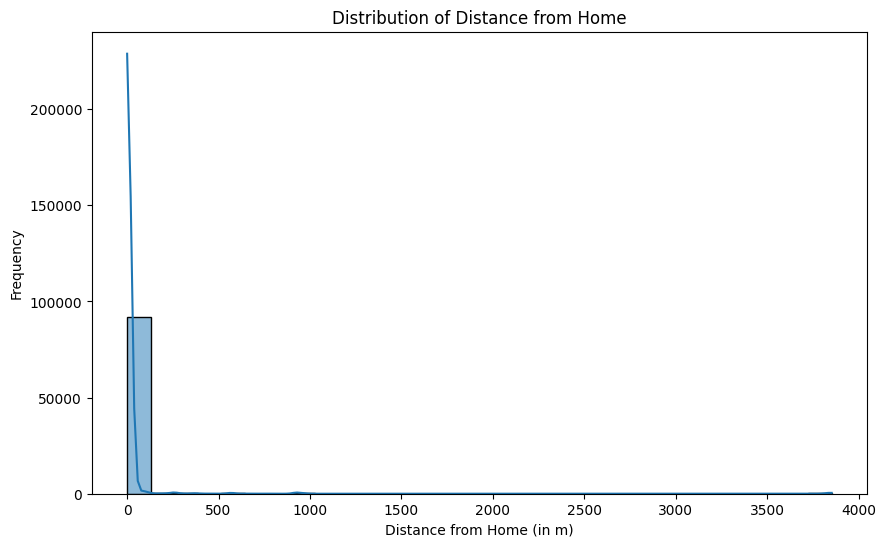

In [106]:
## Plot ther histogram of the dist_from_home column
plt.figure(figsize=(10, 6))
sns.histplot(processed_compliance_matrix['dist_from_home'].dropna(), bins=30, kde=True)
plt.title('Distribution of Distance from Home')
plt.xlabel('Distance from Home (in m)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

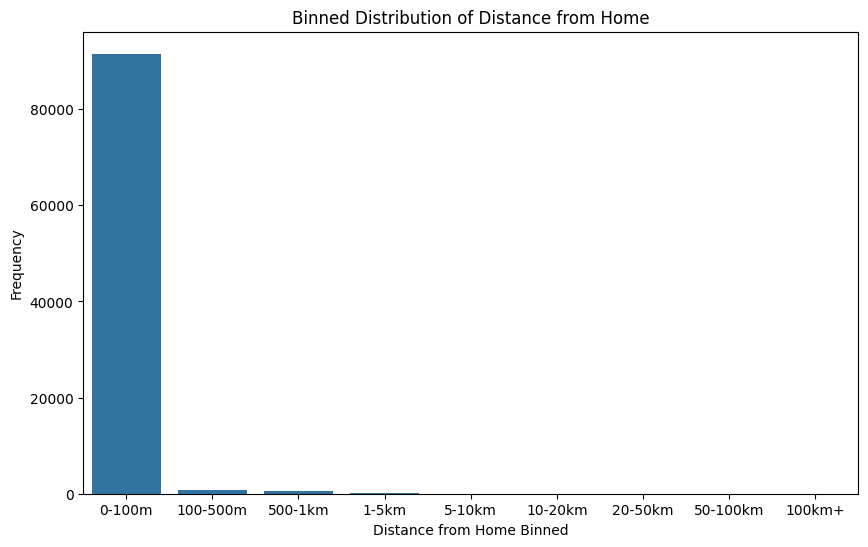

In [107]:
## Create a binned plot of the dist_from_home column
plt.figure(figsize=(10, 6))
bins = [0, 100, 500, 1000, 5000, 10000, 20000, 50000, 100000, np.inf]
labels = ['0-100m', '100-500m', '500-1km', '1-5km', '5-10km', '10-20km', '20-50km', '50-100km', '100km+']
processed_compliance_matrix['dist_from_home_binned'] = pd.cut(processed_compliance_matrix['dist_from_home'], bins=bins, labels=labels, right=False)
sns.countplot(data=processed_compliance_matrix, x='dist_from_home_binned', order=labels)
plt.title('Binned Distribution of Distance from Home')
plt.xlabel('Distance from Home Binned')
plt.ylabel('Frequency')

### Phone lock
Whether the phone is currently locked or in active use

In [108]:
## Get the distribution of phone lock status
phone_lock_status_counts = processed_compliance_matrix['PHONE_LOCK'].value_counts()
print("Distribution of PHONE_LOCK_STATUS:")
print(phone_lock_status_counts)

Distribution of PHONE_LOCK_STATUS:
PHONE_LOCK
Phone Locked      68627
Phone Unlocked    24531
NF                14917
Name: count, dtype: int64


In [109]:
## Create a new column is_phone_locked. It is 1 if 'Phone Locked', 0 if 'Phone Unlocked', and NaN if 'NF'.
processed_compliance_matrix['is_phone_locked'] = processed_compliance_matrix['PHONE_LOCK'].apply(
    lambda x: 1 if x == 'Phone Locked' else (0 if x == 'Phone Unlocked' else np.nan)
)
# Show the first few rows of the processed compliance matrix with the new is_phone_locked column
print(processed_compliance_matrix['is_phone_locked'].head(10))  

132810    1.0
132811    1.0
132812    1.0
132813    1.0
132814    1.0
132815    1.0
132816    0.0
132817    0.0
132818    1.0
132819    1.0
Name: is_phone_locked, dtype: float64


In [111]:
## Get the distribution of phone lock status
phone_lock_status_counts = processed_compliance_matrix['is_phone_locked'].value_counts()
print("Distribution of is_phone_locked:")
print(phone_lock_status_counts)

## Count the % of NaN values in the is_phone_locked column
nan_is_phone_locked_percentage = processed_compliance_matrix['is_phone_locked'].isna().mean() * 100
print(f"Percentage of NaN values in is_phone_locked: {nan_is_phone_locked_percentage:.2f}%")

Distribution of is_phone_locked:
is_phone_locked
1.0    68627
0.0    24531
Name: count, dtype: int64
Percentage of NaN values in is_phone_locked: 13.80%


### Last phone usage
When the phone was used last time from the uEMA prompt

Last Phone Usage column data:
132810    60.0
132811     1.1
132812     5.3
132813    13.4
132814    21.3
Name: LAST_USAGE_DURATION, dtype: object
132810    60.0
132811     1.1
132812     5.3
132813    13.4
132814    21.3
Name: LAST_USAGE_DURATION, dtype: float64
Descriptive statistics of LAST_USAGE_DURATION:
count    93158.000000
mean        19.985186
std         22.705493
min          0.000000
25%          0.000000
50%          9.300000
75%         37.200000
max         60.000000
Name: LAST_USAGE_DURATION, dtype: float64


Text(0, 0.5, 'Frequency')

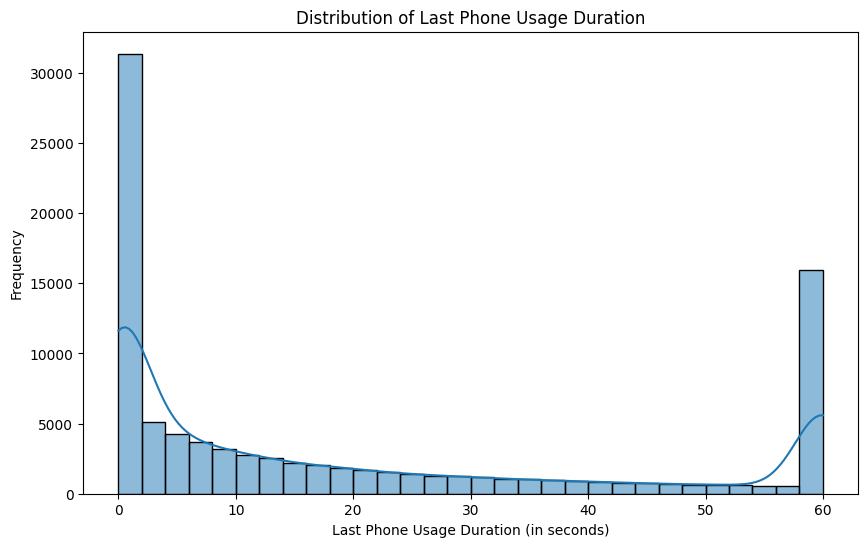

In [115]:
## Show the preview of the last phone usage column
print("Last Phone Usage column data:")
print(processed_compliance_matrix['LAST_USAGE_DURATION'].head(5))

# Convert LAST_USAGE_DURATION to a numeric value. Coerce NaN wherever necessary
processed_compliance_matrix['LAST_USAGE_DURATION'] = pd.to_numeric(processed_compliance_matrix['LAST_USAGE_DURATION'], errors='coerce')
# Show the first few rows of the processed compliance matrix with the new LAST_USAGE_DURATION column
print(processed_compliance_matrix['LAST_USAGE_DURATION'].head(5))
## Get the descriptive statistics of the LAST_USAGE_DURATION column
last_usage_duration_stats = processed_compliance_matrix['LAST_USAGE_DURATION'].describe()
print("Descriptive statistics of LAST_USAGE_DURATION:")
print(last_usage_duration_stats)
# Plot the distribution of LAST_USAGE_DURATION
plt.figure(figsize=(10, 6))
sns.histplot(processed_compliance_matrix['LAST_USAGE_DURATION'].dropna(), bins=30, kde=True)
plt.title('Distribution of Last Phone Usage Duration')
plt.xlabel('Last Phone Usage Duration (in seconds)')
plt.ylabel('Frequency')

In [116]:
## Create a new column 'last_phone_usage' that is just a copy of the LAST_USAGE_DURATION column
processed_compliance_matrix['last_phone_usage'] = processed_compliance_matrix['LAST_USAGE_DURATION']
# Show the first few rows of the processed compliance matrix with the new last_phone_usage column
print(processed_compliance_matrix['last_phone_usage'].head(5))

132810    60.0
132811     1.1
132812     5.3
132813    13.4
132814    21.3
Name: last_phone_usage, dtype: float64


### Waking day parts
If only considering sleep and wake times, how does the romtp stack up against those times

In [120]:
## SHow the prview of parts of waking day column
print("Waking Day Parts column data:")
print(processed_compliance_matrix['PARTS_OF_WAKING_HOUR'].head(5))
# Show the unique values in the PARTS_OF_WAKING_DAY column
print("Unique values in PARTS_OF_WAKING_DAY column:")
print(processed_compliance_matrix['PARTS_OF_WAKING_HOUR'].unique())
## Show the frequency table of the PARTS_OF_WAKING_HOUR column
waking_day_parts_counts = processed_compliance_matrix['PARTS_OF_WAKING_HOUR'].value_counts()
print("Frequency table of PARTS_OF_WAKING_HOUR:")
print(waking_day_parts_counts)
## Count the number of NaN values in the PARTS_OF_WAKING_HOUR column
nan_waking_day_parts_count = processed_compliance_matrix['PARTS_OF_WAKING_HOUR'].isna().sum()
print(f"Number of NaN values in PARTS_OF_WAKING_HOUR: {nan_waking_day_parts_count}") 

Waking Day Parts column data:
132810    2.0
132811    2.0
132812    2.0
132813    2.0
132814    2.0
Name: PARTS_OF_WAKING_HOUR, dtype: float64
Unique values in PARTS_OF_WAKING_DAY column:
[ 2.  3.  0.  1.  4. -2. -1. -3.  5.  6. nan]
Frequency table of PARTS_OF_WAKING_HOUR:
PARTS_OF_WAKING_HOUR
 1.0    28973
 2.0    28542
 3.0    25159
 0.0    25129
 4.0       89
-2.0       49
-3.0       47
-1.0       24
 6.0        8
 5.0        7
Name: count, dtype: int64
Number of NaN values in PARTS_OF_WAKING_HOUR: 48


In [126]:
## Print dataframe rows with sleep time, wake time and waking day parts column.
## But print only those rows where the PARTS_OF_WAKING_HOUR column is 4.0, -2.0, -3.0, -1.0, 6.0, and 5.0
## Randomly sample 3 instances from each of the waking day parts of interest.
waking_day_parts_of_interest = [4.0, -2.0, -3.0, -1.0, 6.0, 5.0]
filtered_waking_day_parts = processed_compliance_matrix[processed_compliance_matrix['PARTS_OF_WAKING_HOUR'].isin(waking_day_parts_of_interest)]
# Randomly sample 2 instances from each of the waking day parts of interest
sampled_waking_day_parts = filtered_waking_day_parts.groupby('PARTS_OF_WAKING_HOUR').apply(lambda x: x.sample(2, random_state=42)).reset_index(drop=True)
# Show the sampled waking day parts dataframe
print("Sampled Waking Day Parts DataFrame:")
print(sampled_waking_day_parts[['WAKE_TIME', 'Initial_Prompt_Local_Time', 'SLEEP_TIME', 'PARTS_OF_WAKING_HOUR']])


Sampled Waking Day Parts DataFrame:
                  WAKE_TIME     Initial_Prompt_Local_Time  \
0   2021-05-20 15:00:00 PDT  Thu May 20 05:32:03 PDT 2021   
1   2021-05-27 16:00:00 PDT  Thu May 27 06:47:03 PDT 2021   
2   2021-05-28 14:00:00 PDT  Fri May 28 07:23:03 PDT 2021   
3   2021-05-26 14:00:00 PDT  Wed May 26 05:27:02 PDT 2021   
4   2022-02-11 09:00:00 EST  Fri Feb 11 08:54:03 CST 2022   
5   2022-04-17 10:00:00 CDT  Sun Apr 17 09:42:03 MDT 2022   
6   2021-04-07 10:30:00 PDT  Thu Apr 08 03:54:04 PDT 2021   
7   2020-12-22 11:00:00 PST  Wed Dec 23 03:25:04 PST 2020   
8   2020-11-10 22:30:00 PST  Wed Nov 11 03:46:03 PST 2020   
9   2020-11-10 22:30:00 PST  Wed Nov 11 03:54:03 PST 2020   
10  2022-04-13 09:00:00 CDT  Thu Apr 14 03:25:02 CDT 2022   
11  2022-04-13 09:00:00 CDT  Thu Apr 14 04:27:03 CDT 2022   

                 SLEEP_TIME  PARTS_OF_WAKING_HOUR  
0   2021-05-21 07:00:00 PDT                  -3.0  
1   2021-05-28 07:00:00 PDT                  -3.0  
2   2021-05-29

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_45934/3376497872.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_waking_day_parts = filtered_waking_day_parts.groupby('PARTS_OF_WAKING_HOUR').apply(lambda x: x.sample(2, random_state=42)).reset_index(drop=True)


In [128]:
## Create a new column called wake_day_part based on the PARTS_OF_WAKING_HOUR column.
## Keep the values as they are. But change the negatuive values to positive values.
## Also, change values that 4, 5, or 6 to 3.0
processed_compliance_matrix['wake_day_part'] = processed_compliance_matrix['PARTS_OF_WAKING_HOUR'].apply(
    lambda x: abs(x) if x < 0 else (3.0 if x in [4.0, 5.0, 6.0] else x)
)
# Show the first few rows of the processed compliance matrix with the new wake_day_part column
print(processed_compliance_matrix['wake_day_part'].head(5))
## Get the distribution of the wake_day_part column 
wake_day_part_counts = processed_compliance_matrix['wake_day_part'].value_counts(normalize=True) * 100
print("Distribution of wake_day_part in percentage:")
print(wake_day_part_counts)

## Print the % of NaN values in the wake_day_part column
nan_wake_day_part_percentage = processed_compliance_matrix['wake_day_part'].isna().mean() * 100
print(f"Percentage of NaN values in wake_day_part: {nan_wake_day_part_percentage:.2f}%")

132810    2.0
132811    2.0
132812    2.0
132813    2.0
132814    2.0
Name: wake_day_part, dtype: float64
Distribution of wake_day_part in percentage:
wake_day_part
1.0    26.842363
2.0    26.466532
3.0    23.429328
0.0    23.261777
Name: proportion, dtype: float64
Percentage of NaN values in wake_day_part: 0.04%


### CLoseness to sleep time vs wake time
feature for how close is a prompt to the sleep and wake times

In [130]:
## Show the first 5 rows with proximity to sleep and wake time columns. This value is in minutes
print("First 5 rows with proximity to sleep and wake times:")
print(processed_compliance_matrix[['PROXIMITY_TO_SLEEP_TIME', 'PROXIMITY_TO_WAKE_TIME', 'SLEEP_TIME', 'WAKE_TIME', 'Initial_Prompt_Local_Time']].head(5))


First 5 rows with proximity to sleep and wake times:
        PROXIMITY_TO_SLEEP_TIME  PROXIMITY_TO_WAKE_TIME  \
132810               396.916667              593.083333   
132811               359.933333              630.066667   
132812               351.933333              638.066667   
132813               343.766667              646.233333   
132814               335.950000              654.050000   

                     SLEEP_TIME                WAKE_TIME  \
132810  2021-02-22 23:30:00 PST  2021-02-22 07:00:00 PST   
132811  2021-02-22 23:30:00 PST  2021-02-22 07:00:00 PST   
132812  2021-02-22 23:30:00 PST  2021-02-22 07:00:00 PST   
132813  2021-02-22 23:30:00 PST  2021-02-22 07:00:00 PST   
132814  2021-02-22 23:30:00 PST  2021-02-22 07:00:00 PST   

           Initial_Prompt_Local_Time  
132810  Mon Feb 22 16:53:05 PST 2021  
132811  Mon Feb 22 17:30:04 PST 2021  
132812  Mon Feb 22 17:38:04 PST 2021  
132813  Mon Feb 22 17:46:14 PST 2021  
132814  Mon Feb 22 17:54:03 PST 2021

In [131]:
## Create two new columns 'closeness_to_sleep_time' and 'closeness_to_wake_time' that are numeric values of PROXIMITY_TO_SLEEP_TIME and PROXIMITY_TO_WAKE_TIME columns.
processed_compliance_matrix['closeness_to_sleep_time'] = pd.to_numeric(processed_compliance_matrix['PROXIMITY_TO_SLEEP_TIME'], errors='coerce')
processed_compliance_matrix['closeness_to_wake_time'] = pd.to_numeric(processed_compliance_matrix['PROXIMITY_TO_WAKE_TIME'], errors='coerce')
# Show the first few rows of the processed compliance matrix with the new closeness_to_sleep_time and closeness_to_wake_time columns
print(processed_compliance_matrix[['closeness_to_sleep_time', 'closeness_to_wake_time']].head(5))

        closeness_to_sleep_time  closeness_to_wake_time
132810               396.916667              593.083333
132811               359.933333              630.066667
132812               351.933333              638.066667
132813               343.766667              646.233333
132814               335.950000              654.050000


In [132]:
## Get the % of NaN values in the closeness_to_sleep_time and closeness_to_wake_time columns
nan_closeness_to_sleep_time_percentage = processed_compliance_matrix['closeness_to_sleep_time'].isna().mean() * 100
nan_closeness_to_wake_time_percentage = processed_compliance_matrix['closeness_to_wake_time'].isna().mean() * 100
print(f"Percentage of NaN values in closeness_to_sleep_time: {nan_closeness_to_sleep_time_percentage:.2f}%")
print(f"Percentage of NaN values in closeness_to_wake_time: {nan_closeness_to_wake_time_percentage:.2f}%")

Percentage of NaN values in closeness_to_sleep_time: 0.04%
Percentage of NaN values in closeness_to_wake_time: 0.04%


### Activity or motion levels
Computed using MIMS values 5 min before the prompt

In [134]:
## SHow the first few rows of mims_5_min_before_prompt column
print("First few rows of mims_5_min_before_prompt column:")
print(processed_compliance_matrix['mims_summary_5min'].head(5))
## Get the data type of the mims_5_min_before_prompt column
print("Data type of mims_5_min_before_prompt column:")
print(processed_compliance_matrix['mims_summary_5min'].dtype)

First few rows of mims_5_min_before_prompt column:
132810    57.173306
132811    49.208356
132812    58.736786
132813    48.153617
132814    78.414312
Name: mims_summary_5min, dtype: object
Data type of mims_5_min_before_prompt column:
object


First few rows of processed compliance matrix with mims_5min column:
132810    57.173306
132811    49.208356
132812    58.736786
132813    48.153617
132814    78.414312
Name: mims_5min, dtype: float64
Descriptive statistics of mims_5min:
count    103725.000000
mean         46.980886
std          48.242284
min           0.000000
25%          12.056446
50%          31.988780
75%          68.820558
max         805.180255
Name: mims_5min, dtype: float64


Text(0, 0.5, 'Frequency')

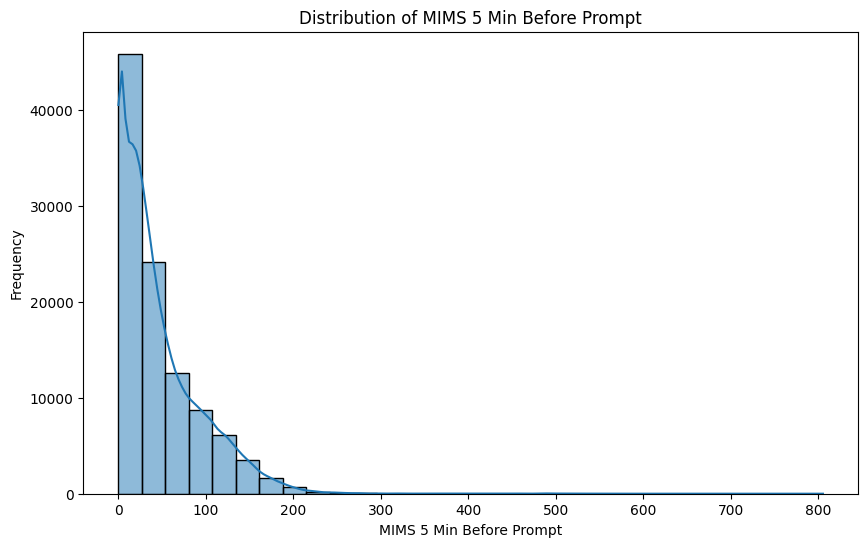

In [135]:
## Add a new column called mims_5min that is the float value of the mims_summary_5min column.
processed_compliance_matrix['mims_5min'] = pd.to_numeric(processed_compliance_matrix['mims_summary_5min'], errors='coerce')
# Show the first few rows of the processed compliance matrix with the new mims_5min column
print("First few rows of processed compliance matrix with mims_5min column:")
print(processed_compliance_matrix['mims_5min'].head(5))
## Get the distribution of the mims_5min column using describe()
mims_5min_stats = processed_compliance_matrix['mims_5min'].describe()
print("Descriptive statistics of mims_5min:")
print(mims_5min_stats)
## Plot the distribution of mims_5min column
plt.figure(figsize=(10, 6))
sns.histplot(processed_compliance_matrix['mims_5min'].dropna(), bins=30, kde=True)
plt.title('Distribution of MIMS 5 Min Before Prompt')
plt.xlabel('MIMS 5 Min Before Prompt')
plt.ylabel('Frequency')

## Slow moving features
These are also accumulating features that take information from the previous events of the current prompt

### Days of exposure
Number of days participant has sustained responding to the prompts on uEMA

In [145]:
## Get the first 5 rows of days in study column with intial prompt date column
print("First 5 rows of Days_In_Study column with Initial_Prompt_Date:")
print("First 5 rows of Days_In_Study column:")
print(processed_compliance_matrix[['Line', 'Initial_Prompt_Date']].head(10))

First 5 rows of Days_In_Study column with Initial_Prompt_Date:
First 5 rows of Days_In_Study column:
        Line Initial_Prompt_Date
132810     1          2021-02-22
132811     2          2021-02-22
132812     3          2021-02-22
132813     4          2021-02-22
132814     5          2021-02-22
132815     6          2021-02-22
132816     7          2021-02-22
132817     8          2021-02-22
132818     9          2021-02-22
132819    10          2021-02-22


In [146]:
## First sort the compliance matrix by Initial_Prompt_Date but grouped within each participant
processed_compliance_matrix.sort_values(by=['Participant_ID', 'Initial_Prompt_Date'], inplace=True)
# Reset the index
processed_compliance_matrix.reset_index(drop=True, inplace=True)
## Preview the first few rows of the processed compliance matrix
print("First few rows of the processed compliance matrix after sorting:")
print(processed_compliance_matrix.head(10))

First few rows of the processed compliance matrix after sorting:
                            Participant_ID Initial_Prompt_Date   Prompt_Type  \
0  certifiedembargobartender@timestudy_com          2021-04-30     EMA_Micro   
1  certifiedembargobartender@timestudy_com          2021-04-30     EMA_Micro   
2  certifiedembargobartender@timestudy_com          2021-04-30     EMA_Micro   
3  certifiedembargobartender@timestudy_com          2021-04-30     EMA_Micro   
4  certifiedembargobartender@timestudy_com          2021-04-30     EMA_Micro   
5  certifiedembargobartender@timestudy_com          2021-04-30     EMA_Micro   
6  certifiedembargobartender@timestudy_com          2021-04-30     EMA_Micro   
7  certifiedembargobartender@timestudy_com          2021-04-30     EMA_Micro   
8  certifiedembargobartender@timestudy_com          2021-04-30  CS_EMA_Micro   
9  certifiedembargobartender@timestudy_com          2021-04-30     EMA_Micro   

  Study_Mode     Initial_Prompt_Local_Time Answer_Stat

In [149]:
## Preview the first 10 and last 10 rows of the processed compliance matrix for 'neutergoldfishsworn@timestudy_com' participant
participant_id = 'neutergoldfishsworn@timestudy_com'
participant_data = processed_compliance_matrix[processed_compliance_matrix['Participant_ID'] == participant_id]
print(f"First 10 rows for participant {participant_id}:")
print(participant_data.head(10))
print(f"Last 10 rows for participant {participant_id}:")
print(participant_data.tail(10))

First 10 rows for participant neutergoldfishsworn@timestudy_com:
                          Participant_ID Initial_Prompt_Date  \
39752  neutergoldfishsworn@timestudy_com          2020-07-08   
39753  neutergoldfishsworn@timestudy_com          2020-07-08   
39754  neutergoldfishsworn@timestudy_com          2020-07-08   
39755  neutergoldfishsworn@timestudy_com          2020-07-08   
39756  neutergoldfishsworn@timestudy_com          2020-07-08   
39757  neutergoldfishsworn@timestudy_com          2020-07-08   
39758  neutergoldfishsworn@timestudy_com          2020-07-08   
39759  neutergoldfishsworn@timestudy_com          2020-07-08   
39760  neutergoldfishsworn@timestudy_com          2020-07-08   
39761  neutergoldfishsworn@timestudy_com          2020-07-08   

            Prompt_Type Study_Mode     Initial_Prompt_Local_Time  \
39752         EMA_Micro       TIME  Wed Jul 08 08:30:03 PDT 2020   
39753         EMA_Micro       TIME  Wed Jul 08 08:44:02 PDT 2020   
39754  Trivia_EMA_Micro   

In [139]:
## Create a new column called days_in_study that is the number of days since the initial prompt date. The first day should be 0.
## Calculate this grouped by participant_id.


First few rows of processed compliance matrix with days_in_study column:
                           Participant_ID Initial_Prompt_Date  days_in_study
132810  neutergoldfishsworn@timestudy_com          2021-02-22            229
132811  neutergoldfishsworn@timestudy_com          2021-02-22            229
132812  neutergoldfishsworn@timestudy_com          2021-02-22            229
132813  neutergoldfishsworn@timestudy_com          2021-02-22            229
132814  neutergoldfishsworn@timestudy_com          2021-02-22            229
132815  neutergoldfishsworn@timestudy_com          2021-02-22            229
132816  neutergoldfishsworn@timestudy_com          2021-02-22            229
132817  neutergoldfishsworn@timestudy_com          2021-02-22            229
132818  neutergoldfishsworn@timestudy_com          2021-02-22            229
132819  neutergoldfishsworn@timestudy_com          2021-02-22            229


In [140]:
## Preview compliance matrix head and tail
print("Head of processed compliance matrix:")
print(processed_compliance_matrix.head(10))
print("Tail of processed compliance matrix:")
print(processed_compliance_matrix.tail(10))

Head of processed compliance matrix:
                           Participant_ID Initial_Prompt_Date  \
132810  neutergoldfishsworn@timestudy_com          2021-02-22   
132811  neutergoldfishsworn@timestudy_com          2021-02-22   
132812  neutergoldfishsworn@timestudy_com          2021-02-22   
132813  neutergoldfishsworn@timestudy_com          2021-02-22   
132814  neutergoldfishsworn@timestudy_com          2021-02-22   
132815  neutergoldfishsworn@timestudy_com          2021-02-22   
132816  neutergoldfishsworn@timestudy_com          2021-02-22   
132817  neutergoldfishsworn@timestudy_com          2021-02-22   
132818  neutergoldfishsworn@timestudy_com          2021-02-22   
132819  neutergoldfishsworn@timestudy_com          2021-02-22   

             Prompt_Type Study_Mode     Initial_Prompt_Local_Time  \
132810         EMA_Micro       TIME  Mon Feb 22 16:53:05 PST 2021   
132811      CS_EMA_Micro       TIME  Mon Feb 22 17:30:04 PST 2021   
132812         EMA_Micro       TIME  Mon

In [148]:
## Update the days_in_study column to be the number of days since the initial prompt date, for each participant. The first day should be 0
def calculate_days_in_study(group):
    group = group.copy()
    group['days_in_study'] = (group['Initial_Prompt_Date'] - group['Initial_Prompt_Date'].min()).dt.days
    return group
# Apply the function to each group of participant_id
processed_compliance_matrix['Initial_Prompt_Date'] = pd.to_datetime(processed_compliance_matrix['Initial_Prompt_Date'])
processed_compliance_matrix = processed_compliance_matrix.groupby('Participant_ID').apply(calculate_days_in_study).reset_index(drop=True)
# Show the first few rows of the processed compliance matrix with the new days_in_study column
print("First few rows of the processed compliance matrix with days_in_study column:")
print(processed_compliance_matrix[['Participant_ID', 'Initial_Prompt_Date', 'days_in_study']].head(10))

First few rows of the processed compliance matrix with days_in_study column:
                            Participant_ID Initial_Prompt_Date  days_in_study
0  certifiedembargobartender@timestudy_com          2021-04-30              0
1  certifiedembargobartender@timestudy_com          2021-04-30              0
2  certifiedembargobartender@timestudy_com          2021-04-30              0
3  certifiedembargobartender@timestudy_com          2021-04-30              0
4  certifiedembargobartender@timestudy_com          2021-04-30              0
5  certifiedembargobartender@timestudy_com          2021-04-30              0
6  certifiedembargobartender@timestudy_com          2021-04-30              0
7  certifiedembargobartender@timestudy_com          2021-04-30              0
8  certifiedembargobartender@timestudy_com          2021-04-30              0
9  certifiedembargobartender@timestudy_com          2021-04-30              0


/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_45934/412760706.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_compliance_matrix = processed_compliance_matrix.groupby('Participant_ID').apply(calculate_days_in_study).reset_index(drop=True)


### Completion in last 24 hours
For each prompt, we will compute the completion rate in the last 24 hours

In [164]:

## Print the data type of actual_prompt_local_time column
print("Data type of Actual_Prompt_Local_Time column:")
print(processed_compliance_matrix['Actual_Prompt_Local_Time'].dtype)

Data type of Actual_Prompt_Local_Time column:
object


In [166]:
def convert_object_to_datetime_with_ms(date_str):
    """
    Converts a string like 'Mon Feb 22 16:53:05 PST 2021' to a datetime object with format '%Y-%m-%d %H:%M:%S.%f'.
    Removes the timezone (any 3-letter word) and parses the rest. Returns NaT if parsing fails.
    """
    import re
    import pandas as pd
    if pd.isna(date_str):
        return pd.NaT
    # Remove the timezone (assumed to be a 3-letter word at position 20-22)
    # Example: 'Mon Feb 22 16:53:05 PST 2021' -> 'Mon Feb 22 16:53:05 2021'
    try:
        s = str(date_str)
        # Use regex to remove the timezone (3 letters surrounded by spaces)
        s = re.sub(r' ([A-Z]{3}) ', ' ', s)
        # Parse to datetime, add .%f for milliseconds (if present, else will be 0)
        dt = pd.to_datetime(s, format='%a %b %d %H:%M:%S %Y', errors='coerce')
        return dt
    except Exception as e:
        return pd.NaT

# Example usage:
# df['datetime_col'] = df['object_col'].apply(convert_object_to_datetime_with_ms)

## Apply the function by creating a new column called prompt_time_converted
processed_compliance_matrix['prompt_time_converted'] = processed_compliance_matrix['Actual_Prompt_Local_Time'].apply(convert_object_to_datetime_with_ms)
# Show the first few rows of the processed compliance matrix with the new prompt_time_converted column
print("First few rows of the processed compliance matrix with prompt_time_converted column:")
print(processed_compliance_matrix[['Actual_Prompt_Local_Time', 'prompt_time_converted']].head(10))

First few rows of the processed compliance matrix with prompt_time_converted column:
       Actual_Prompt_Local_Time prompt_time_converted
0  Fri Apr 30 18:22:00 CDT 2021   2021-04-30 18:22:00
1  Fri Apr 30 18:33:02 CDT 2021   2021-04-30 18:33:02
2  Fri Apr 30 18:46:03 CDT 2021   2021-04-30 18:46:03
3  Fri Apr 30 18:54:01 CDT 2021   2021-04-30 18:54:01
4  Fri Apr 30 19:13:01 CDT 2021   2021-04-30 19:13:01
5  Fri Apr 30 19:21:02 CDT 2021   2021-04-30 19:21:02
6  Fri Apr 30 19:35:06 CDT 2021   2021-04-30 19:35:06
7  Fri Apr 30 20:18:01 CDT 2021   2021-04-30 20:18:01
8  Fri Apr 30 20:30:01 CDT 2021   2021-04-30 20:30:01
9  Fri Apr 30 20:44:04 CDT 2021   2021-04-30 20:44:04


In [168]:
## Calculate completion rate in the past 24 hours for each observation
def calculate_completion_24h(df):
    # Ensure prompt_time_converted is a datetime object (should already be, but enforce)
    df = df.copy()
    df['prompt_time_converted'] = pd.to_datetime(df['prompt_time_converted'], errors='coerce')
    # Sort by Participant_ID and prompt_time_converted in ascending order
    df = df.sort_values(['Participant_ID', 'prompt_time_converted']).reset_index(drop=True)
    completion_rates = []
    for idx, row in df.iterrows():
        current_time = row['prompt_time_converted']
        # Filter observations in the last 24 hours for the same participant
        mask = (df['Participant_ID'] == row['Participant_ID']) & \
               (df['prompt_time_converted'] >= current_time - pd.Timedelta(hours=24)) & \
               (df['prompt_time_converted'] < current_time)
        last_24h = df[mask]
        if len(last_24h) == 0:
            completion_rates.append(0)
        else:
            rate = last_24h['Outcome'].sum() / len(last_24h)
            completion_rates.append(rate)
    return completion_rates

# Apply the function and save as completion_24h column
processed_compliance_matrix['completion_24h'] = calculate_completion_24h(processed_compliance_matrix)
# Show the first few rows of the processed compliance matrix with the new completion_24h column
print(processed_compliance_matrix[['Participant_ID', 'prompt_time_converted', 'completion_24h']].head(10))

                            Participant_ID prompt_time_converted  \
0  certifiedembargobartender@timestudy_com   2021-04-30 18:22:00   
1  certifiedembargobartender@timestudy_com   2021-04-30 18:33:02   
2  certifiedembargobartender@timestudy_com   2021-04-30 18:46:03   
3  certifiedembargobartender@timestudy_com   2021-04-30 18:54:01   
4  certifiedembargobartender@timestudy_com   2021-04-30 19:13:01   
5  certifiedembargobartender@timestudy_com   2021-04-30 19:21:02   
6  certifiedembargobartender@timestudy_com   2021-04-30 19:35:06   
7  certifiedembargobartender@timestudy_com   2021-04-30 20:18:01   
8  certifiedembargobartender@timestudy_com   2021-04-30 20:30:01   
9  certifiedembargobartender@timestudy_com   2021-04-30 20:44:04   

   completion_24h  
0        0.000000  
1        1.000000  
2        1.000000  
3        1.000000  
4        1.000000  
5        0.800000  
6        0.833333  
7        0.857143  
8        0.875000  
9        0.888889  


In [172]:
## Optimized calculation of completion rate in the past 24 hours for each observation
def calculate_completion_24h_optimized(df):
    df = df.copy()
    df['prompt_time_converted'] = pd.to_datetime(df['prompt_time_converted'], errors='coerce')
    df = df.sort_values(['Participant_ID', 'prompt_time_converted']).reset_index(drop=True)
    completion_24h = np.zeros(len(df))
    
    # Group by participant for efficiency
    for pid, group in df.groupby('Participant_ID'):
        times = group['prompt_time_converted'].values
        outcomes = group['Outcome'].values
        n = len(group)
        # For each observation, find the start index of the 24h window using searchsorted
        for i in range(n):
            # Only consider previous prompts in the last 24 hours
            window_start = times[i] - np.timedelta64(24, 'h')
            # Find the index of the first prompt >= window_start (but < current)
            idx_start = np.searchsorted(times, window_start, side='left')
            idx_end = i  # exclude current prompt
            if idx_start < idx_end:
                window_outcomes = outcomes[idx_start:idx_end]
                completion_24h[group.index[i]] = window_outcomes.sum() / len(window_outcomes)
            else:
                completion_24h[group.index[i]] = 0
    return completion_24h

# Apply the optimized function and save as completion_24h_optimized column
processed_compliance_matrix['completion_24h_optimized'] = calculate_completion_24h_optimized(processed_compliance_matrix)
# Show the first few rows of the processed compliance matrix with the new completion_24h_optimized column
print(processed_compliance_matrix[['Participant_ID', 'prompt_time_converted', 'completion_24h_optimized']].head(10))

                            Participant_ID prompt_time_converted  \
0  certifiedembargobartender@timestudy_com   2021-04-30 18:22:00   
1  certifiedembargobartender@timestudy_com   2021-04-30 18:33:02   
2  certifiedembargobartender@timestudy_com   2021-04-30 18:46:03   
3  certifiedembargobartender@timestudy_com   2021-04-30 18:54:01   
4  certifiedembargobartender@timestudy_com   2021-04-30 19:13:01   
5  certifiedembargobartender@timestudy_com   2021-04-30 19:21:02   
6  certifiedembargobartender@timestudy_com   2021-04-30 19:35:06   
7  certifiedembargobartender@timestudy_com   2021-04-30 20:18:01   
8  certifiedembargobartender@timestudy_com   2021-04-30 20:30:01   
9  certifiedembargobartender@timestudy_com   2021-04-30 20:44:04   

   completion_24h_optimized  
0                  0.000000  
1                  1.000000  
2                  1.000000  
3                  1.000000  
4                  1.000000  
5                  0.800000  
6                  0.833333  
7          

In [170]:
## Print the number of observation for each participant in a table
participant_observation_counts = processed_compliance_matrix['Participant_ID'].value_counts().reset_index()
participant_observation_counts.columns = ['Participant_ID', 'Observation_Count']
print("Number of Observations for Each Participant:")
print(participant_observation_counts)

Number of Observations for Each Participant:
                            Participant_ID  Observation_Count
0  pretendedconstrainfraying@timestudy_com              15440
1    subtitlegrievousbazooka@timestudy_com              13303
2    chewingslouchingfailing@timestudy_com              13283
3         persevereriseswoop@timestudy_com              12993
4  certifiedembargobartender@timestudy_com              11555
5   slapstickporcupineslacks@timestudy_com              11437
6     enjoyergoofinessgrudge@timestudy_com              10457
7        neutergoldfishsworn@timestudy_com               8724
8      remoldexcludingaffair@timestudy_com               6426
9  erasuresafeguardravishing@timestudy_com               4457


### Completion since wake time
We will calculate the completion rate since the wake time of that day.

In [174]:
## First few rows of WAKE_TIME column
print("First few rows of WAKE_TIME column:")
print(processed_compliance_matrix['WAKE_TIME'].head(5))

First few rows of WAKE_TIME column:
0    2021-04-30 06:15:00 CDT
1    2021-04-30 06:15:00 CDT
2    2021-04-30 06:15:00 CDT
3    2021-04-30 06:15:00 CDT
4    2021-04-30 06:15:00 CDT
Name: WAKE_TIME, dtype: object


In [ ]:
## A generic code to convert %Y-%m-%d %H:%M:%S XYZ format to datetime object
## First ignore the last 3 letters for the timezone, then convert to %Y-%m-%d %H:%M:%S format datetime object.

def convert_datetime_remove_tz(date_str):
    """
    Converts a string like '2025-06-08 14:23:45 PST' to a datetime object with format '%Y-%m-%d %H:%M:%S'.
    Removes the last 3-letter timezone and parses the rest. Returns NaT if parsing fails.
    """
    import pandas as pd
    if pd.isna(date_str):
        return pd.NaT
    try:
        # Remove the last 4 characters (space + 3-letter timezone)
        s = str(date_str)[:-4]
        dt = pd.to_datetime(s, format='%Y-%m-%d %H:%M:%S', errors='coerce')
        return dt
    except Exception as e:
        return pd.NaT

# Example usage:
# df['datetime_col'] = df['object_col'].apply(convert_datetime_remove_tz)

# Use this function to convert the WAKE_TIME column
processed_compliance_matrix['WAKE_TIME_converted'] = processed_compliance_matrix['WAKE_TIME'].apply(convert_datetime_remove_tz)
# Show the first few rows of the processed compliance matrix with the new WAKE_TIME_converted column
print("First few rows of the processed compliance matrix with WAKE_TIME_converted column:")
print(processed_compliance_matrix[['WAKE_TIME', 'WAKE_TIME_converted']].head(10))

First few rows of the processed compliance matrix with WAKE_TIME_converted column:
                 WAKE_TIME WAKE_TIME_converted
0  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00
1  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00
2  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00
3  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00
4  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00
5  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00
6  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00
7  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00
8  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00
9  2021-04-30 06:15:00 CDT 2021-04-30 06:15:00


In [ ]:
## Compute completion_wake_time


In [186]:
def calculate_completion_since_wake_time(df):
    """
    For each observation, computes the completion rate since the most recent wake time (WAKE_TIME_converted), grouped by participant_id.
    Completion rate = number of Outcome==1 since wake time / total observations since wake time (up to and including current prompt).
    """
    import numpy as np
    df = df.copy()
    df['prompt_time_converted'] = pd.to_datetime(df['prompt_time_converted'], errors='coerce')
    df['WAKE_TIME_converted'] = pd.to_datetime(df['WAKE_TIME_converted'], errors='coerce')
    df = df.sort_values(['Participant_ID', 'prompt_time_converted']).reset_index(drop=True)
    completion_since_wake = np.zeros(len(df))
    
    for pid, group in df.groupby('Participant_ID'):
        times = group['prompt_time_converted'].values
        wake_times = group['WAKE_TIME_converted'].values
        outcomes = group['Outcome'].values
        idxs = group.index.values
        for i in range(len(group)):
            # Find all observations since the most recent wake time (including current)
            mask = (times >= wake_times[i]) & (times < times[i])
            n_obs = mask.sum()
            if n_obs == 0:
                completion_since_wake[idxs[i]] = 0
            else:
                completion_since_wake[idxs[i]] = outcomes[mask].sum() / n_obs
    return completion_since_wake

# Example usage:
# processed_compliance_matrix['completion_since_wake'] = calculate_completion_since_wake_time(processed_compliance_matrix)
processed_compliance_matrix['completion_since_wake'] = calculate_completion_since_wake_time(processed_compliance_matrix)
# Show the first few rows of the processed compliance matrix with the new completion_since_wake column
print("First few rows of the processed compliance matrix with completion_since_wake column:")
print(processed_compliance_matrix[['Participant_ID', 'prompt_time_converted', 'WAKE_TIME_converted', 'completion_since_wake']].head(10))

First few rows of the processed compliance matrix with completion_since_wake column:
                            Participant_ID prompt_time_converted  \
0  certifiedembargobartender@timestudy_com   2021-04-30 18:22:00   
1  certifiedembargobartender@timestudy_com   2021-04-30 18:33:02   
2  certifiedembargobartender@timestudy_com   2021-04-30 18:46:03   
3  certifiedembargobartender@timestudy_com   2021-04-30 18:54:01   
4  certifiedembargobartender@timestudy_com   2021-04-30 19:13:01   
5  certifiedembargobartender@timestudy_com   2021-04-30 19:21:02   
6  certifiedembargobartender@timestudy_com   2021-04-30 19:35:06   
7  certifiedembargobartender@timestudy_com   2021-04-30 20:18:01   
8  certifiedembargobartender@timestudy_com   2021-04-30 20:30:01   
9  certifiedembargobartender@timestudy_com   2021-04-30 20:44:04   

  WAKE_TIME_converted  completion_since_wake  
0 2021-04-30 06:15:00               0.000000  
1 2021-04-30 06:15:00               1.000000  
2 2021-04-30 06:15:00    

### Completion rate since start
In this section we will compute the completion rate since the start of the study for each participant.

In [187]:
## Add function to compute completion rate since start of study
def calculate_completion_since_start(df):
    """
    For each observation, computes the completion rate since the start of the study (Initial_Prompt_Date), grouped by participant_id.
    Completion rate = number of Outcome==1 since start / total observations since start (up to and including current prompt).
    """
    import numpy as np
    df = df.copy()
    df['prompt_time_converted'] = pd.to_datetime(df['prompt_time_converted'], errors='coerce')
    df['Initial_Prompt_Date'] = pd.to_datetime(df['Initial_Prompt_Date'], errors='coerce')
    df = df.sort_values(['Participant_ID', 'prompt_time_converted']).reset_index(drop=True)
    completion_since_start = np.zeros(len(df))
    
    for pid, group in df.groupby('Participant_ID'):
        times = group['prompt_time_converted'].values
        initial_times = group['Initial_Prompt_Date'].values
        outcomes = group['Outcome'].values
        idxs = group.index.values
        for i in range(len(group)):
            # Find all observations since the initial prompt date (including current)
            mask = (times >= initial_times[i]) & (times < times[i])
            n_obs = mask.sum()
            if n_obs == 0:
                completion_since_start[idxs[i]] = 0
            else:
                completion_since_start[idxs[i]] = outcomes[mask].sum() / n_obs
    return completion_since_start
# Apply the function to calculate completion since start of study
processed_compliance_matrix['completion_since_start'] = calculate_completion_since_start(processed_compliance_matrix)
# Show the first few rows of the processed compliance matrix with the new completion_since_start column
print("First few rows of the processed compliance matrix with completion_since_start column:")
print(processed_compliance_matrix[['Participant_ID', 'prompt_time_converted', 'Initial_Prompt_Date', 'completion_since_start']].head(10))

First few rows of the processed compliance matrix with completion_since_start column:
                            Participant_ID prompt_time_converted  \
0  certifiedembargobartender@timestudy_com   2021-04-30 18:22:00   
1  certifiedembargobartender@timestudy_com   2021-04-30 18:33:02   
2  certifiedembargobartender@timestudy_com   2021-04-30 18:46:03   
3  certifiedembargobartender@timestudy_com   2021-04-30 18:54:01   
4  certifiedembargobartender@timestudy_com   2021-04-30 19:13:01   
5  certifiedembargobartender@timestudy_com   2021-04-30 19:21:02   
6  certifiedembargobartender@timestudy_com   2021-04-30 19:35:06   
7  certifiedembargobartender@timestudy_com   2021-04-30 20:18:01   
8  certifiedembargobartender@timestudy_com   2021-04-30 20:30:01   
9  certifiedembargobartender@timestudy_com   2021-04-30 20:44:04   

  Initial_Prompt_Date  completion_since_start  
0          2021-04-30                0.000000  
1          2021-04-30                1.000000  
2          2021-04-30

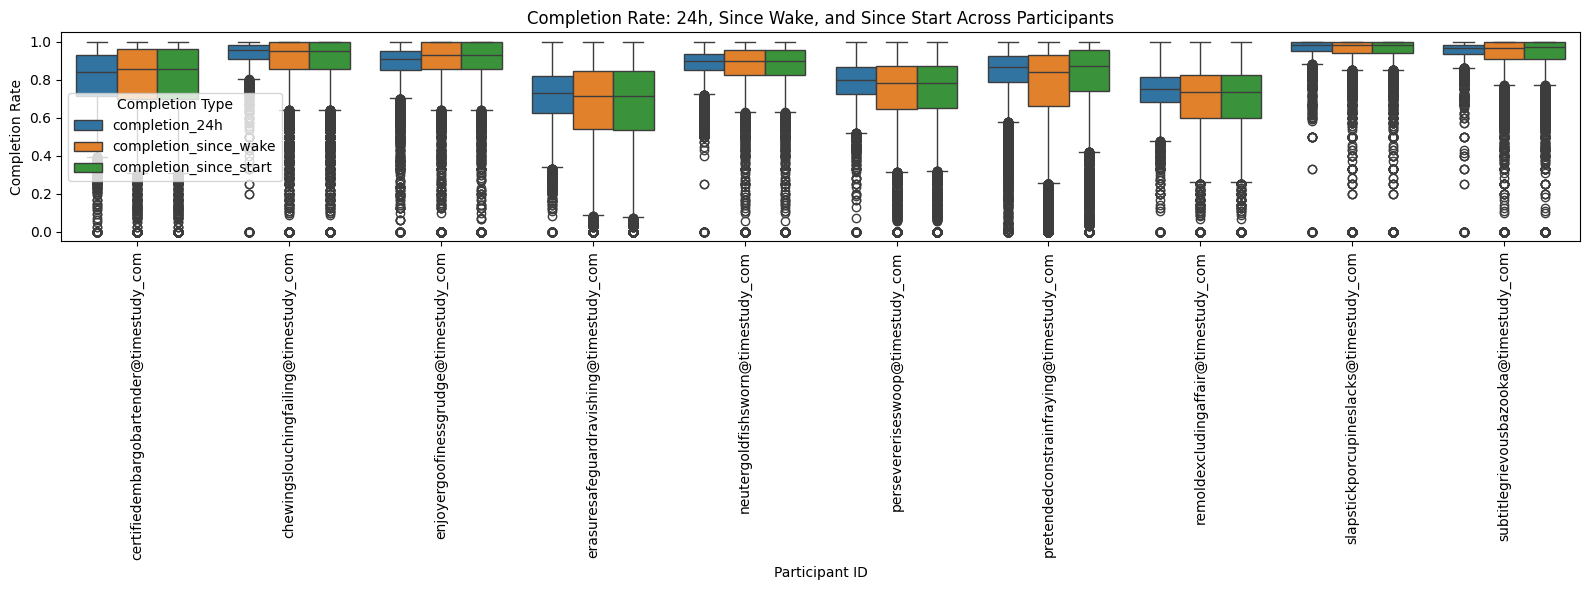

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for side-by-side boxplots for three completion columns
plot_df = processed_compliance_matrix.melt(
    id_vars=['Participant_ID'],
    value_vars=['completion_24h', 'completion_since_wake', 'completion_since_start'],
    var_name='Completion_Type',
    value_name='Completion_Rate'
)

plt.figure(figsize=(16, 6))
sns.boxplot(data=plot_df, x='Participant_ID', y='Completion_Rate', hue='Completion_Type')
plt.xticks(rotation=90)
plt.title('Completion Rate: 24h, Since Wake, and Since Start Across Participants')
plt.xlabel('Participant ID')
plt.ylabel('Completion Rate')
plt.legend(title='Completion Type')
plt.tight_layout()
plt.show()

In [11]:
def split_holdout_and_rl_exploration(compliance_matrix, sampled_compliance_matrix, participant_col='Participant_ID', n_holdout=20, n_rl=17, random_state=42):
    """
    From the original compliance_matrix, keep only participant_ids not in sampled_compliance_matrix.
    Then split into two dataframes:
      1. hold_out: randomly chosen n_holdout participants
      2. rl_exploration: remaining n_rl participants
    Returns: hold_out_df, rl_exploration_df
    """
    import numpy as np
    np.random.seed(random_state)
    # Get participant_ids to keep
    sampled_ids = set(sampled_compliance_matrix[participant_col].unique())
    remaining_df = compliance_matrix[~compliance_matrix[participant_col].isin(sampled_ids)]
    unique_remaining_ids = remaining_df[participant_col].unique()
    if len(unique_remaining_ids) < n_holdout + n_rl:
        raise ValueError(f"Not enough participants to split: found {len(unique_remaining_ids)}, need {n_holdout + n_rl}")
    shuffled_ids = np.random.permutation(unique_remaining_ids)
    holdout_ids = shuffled_ids[:n_holdout]
    rl_ids = shuffled_ids[n_holdout:n_holdout+n_rl]
    hold_out_df = remaining_df[remaining_df[participant_col].isin(holdout_ids)].reset_index(drop=True)
    rl_exploration_df = remaining_df[remaining_df[participant_col].isin(rl_ids)].reset_index(drop=True)
    return hold_out_df, rl_exploration_df

# Example usage:
hold_out_df, rl_exploration_df = split_holdout_and_rl_exploration(compliance_matrix, sampled_compliance_matrix)

In [14]:
import os
base_path = '/Users/adityaponnada/Downloads/time_study_data/compliance_matrix/'
from datetime import datetime

# Example assumes hold_out_df, rl_exploration_df, and compliance_matrix are already defined
# Get the folder of the compliance_matrix file if loaded from CSV
if isinstance(compliance_matrix, pd.DataFrame) and hasattr(compliance_matrix, 'filepath_or_buffer'):
    base_path = os.path.dirname(compliance_matrix.filepath_or_buffer)
else:
    # If not available, set manually or use current directory
    base_path = '/Users/adityaponnada/Downloads/time_study_data/compliance_matrix/'

now_str = datetime.now().strftime('%Y%m%d_%H%M%S')
holdout_path = os.path.join(base_path, f'hold_out_df_{now_str}.csv')
rl_path = os.path.join(base_path, f'rl_exploration_df_{now_str}.csv')
hold_out_df.to_csv(holdout_path, index=False)
rl_exploration_df.to_csv(rl_path, index=False)
print(f'Saved hold_out_df to {holdout_path}')
print(f'Saved rl_exploration_df to {rl_path}')

Saved hold_out_df to /Users/adityaponnada/Downloads/time_study_data/compliance_matrix/hold_out_df_20251007_140441.csv
Saved rl_exploration_df to /Users/adityaponnada/Downloads/time_study_data/compliance_matrix/rl_exploration_df_20251007_140441.csv
